In [1]:
!pip install datasets &> /dev/null
!pip install sacremoses &> /dev/null

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import dataloader, Dataset
from tqdm.auto import tqdm
import os
import matplotlib.pyplot as plt
from datasets import load_dataset
import sacremoses
from sklearn import metrics
import pprint as pp

Using `Glove` word embedding of $6$ billion words with $300$ dimensions embedding size.

In [3]:
!wget https://nlp.stanford.edu/data/glove.6B.zip &> /dev/null

In [4]:
!python -m zipfile -e glove.6B.zip /content/

Loading `imdb` sentiment analysis dataset.

In [5]:
imdb = load_dataset('imdb')

Dataset imdb downloaded and prepared to /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/e3c66f1788a67a89c7058d97ff62b6c30531e05b549de56d3ab91891f0561f9a. Subsequent calls will reuse this data.


Dataset information.

In [23]:
pp.pprint(imdb)

train_ones = np.count_nonzero(imdb['train']['label'])
print(f'''\nTraining dataset:\n - positive samples: {train_ones}\n - negative samples: {len(imdb['train']['label']) - train_ones}\n''')

test_ones = np.count_nonzero(imdb['test']['label'])
print(f'''Test dataset:\n - positive samples: {test_ones}\n - negative samples: {len(imdb['test']['label']) - test_ones}\n''')

{'test': Dataset({
    features: ['label', 'text'],
    num_rows: 25000
}),
 'train': Dataset({
    features: ['label', 'text'],
    num_rows: 25000
}),
 'unsupervised': Dataset({
    features: ['label', 'text'],
    num_rows: 50000
})}

Training dataset:
 - positive samples: 12500
 - negative samples: 12500

Test dataset:
 - positive samples: 12500
 - negative samples: 12500



`imdb` dataset only has `train` and `test` data (`unlabelled` portion does not include valid labels for use). I will use $70\%$ of the `train` dataset for training, $30\%$ of the `train` dataset for `validation` and the entire `test` dataset for `test`ing.

In [6]:
temp = imdb['train'].train_test_split(test_size=0.3)
imdb_train = temp['train'].shuffle()
imdb_val = temp['test'].shuffle()
imdb_test = imdb['test'].shuffle()

In [7]:
train_ones = np.count_nonzero(imdb_train['label'])
print(f'''Training dataset:\n - positive samples: {train_ones}\n - negative samples: {len(imdb_train['label']) - train_ones}\n''')

val_ones = np.count_nonzero(imdb_val['label'])
print(f'''Validation dataset:\n - positive samples: {val_ones}\n - negative samples: {len(imdb_val['label']) - val_ones}\n''')

test_ones = np.count_nonzero(imdb_test['label'])
print(f'''Test dataset:\n - positive samples: {test_ones}\n - negative samples: {len(imdb_test['label']) - test_ones}\n''')

Training dataset:
 - positive samples: 8710
 - negative samples: 8790

Validation dataset:
 - positive samples: 3790
 - negative samples: 3710

Test dataset:
 - positive samples: 12500
 - negative samples: 12500



In [8]:
def load_glove(glove_path, embedding_dim):
  with open(glove_path, encoding = 'utf-8') as f:
    token_ls = [PAD_TOKEN, UNK_TOKEN]
    embedding_ls = [np.zeros(embedding_dim), np.random.rand(embedding_dim)]
    for line in f:
      token, raw_embedding = line.split(' ', 1)
      token_ls.append(token)
      embedding = np.fromstring(raw_embedding, sep=' ')
      embedding_ls.append(embedding)
    embeddings = np.array(embedding_ls)
    return token_ls, embeddings
  
PAD_TOKEN = '<PAD>'
UNK_TOKEN = '<UNK>'
EMBEDDING_DIM = 300

glove_path = 'glove.6B.300d.txt'
vocab, embeddings = load_glove(glove_path, EMBEDDING_DIM)

In [9]:
def tokenize(data, labels, tokenizer, vocab, max_seq_length = 512):
  vocab_to_idx = {word: i for i, word in enumerate(vocab)}
  text_data = []
  label_data = []
  for ex in tqdm(data):
    tokenized = tokenizer.tokenize(ex.lower())
    ids = [vocab_to_idx.get(token,1) for token in tokenized]
    text_data.append(ids)
  return text_data, labels

In [10]:
tokenizer = sacremoses.MosesTokenizer()

In [11]:
train_data_indices,train_labels = tokenize(imdb_train['text'],imdb_train['label'],tokenizer,vocab)
val_data_indices,val_labels = tokenize(imdb_val['text'],imdb_val['label'],tokenizer,vocab)
test_data_indices,test_labels = tokenize(imdb_test['text'],imdb_test['label'],tokenizer,vocab)

In [12]:
print('Train text first 5 examples:\n',train_data_indices[:5])
print('\nTrain labels first 5 examples:\n',train_labels[:5])

Train text first 5 examples:
 [[43, 2717, 5116, 31744, 15, 1, 21, 2, 87, 2921, 1, 108, 69, 304, 2, 2062, 5, 2, 922, 1, 8, 39, 321, 3, 31744, 972, 73, 1158, 21, 9, 222, 17738, 1, 8, 39, 321, 19, 2536, 1786, 14, 1014, 5209, 15865, 21, 64283, 3, 9, 2865, 5660, 40, 852, 21, 9, 83951, 11913, 15, 2, 493, 3, 40, 34262, 6, 401, 9, 1, 2, 2536, 1786, 1412, 9, 5207, 2892, 40, 1383, 73, 45387, 7, 93, 215, 4031, 21, 10835, 3, 2, 17161, 40, 16, 169, 9382, 3, 3240, 7, 1, 31744, 21, 1964, 11198, 14, 69, 33, 6, 2276, 62, 7, 1, 1531, 73, 17161, 7734, 706, 909, 73, 4225, 199, 183, 69, 13394, 22, 21, 9, 243, 8, 73, 1, 1964, 1, 216, 16, 3975, 23, 1097, 8, 2, 675, 324, 439, 635, 5, 52, 198, 117, 108, 22, 304, 94797, 19, 1, 39, 321, 16, 1691, 221, 12, 31, 922, 7, 43, 35, 328, 6, 3712, 5116, 31744, 21, 1964, 21, 145, 21, 70, 2155, 8, 70, 1590, 4], [39, 16, 2, 60, 142, 321, 6, 3598, 5047, 2, 40481, 1137, 182, 23, 5936, 3, 1115, 2, 350, 7, 26161, 3, 12, 24, 340, 9, 1654, 3, 7, 75362, 1, 22, 61, 81, 190, 286, 89

In [13]:
class IMDB(Dataset):
  def __init__(self,data_list,target_list,max_sent_length = 512):
    self.data_list = data_list
    self.target_list = target_list
    self.max_sent_length = max_sent_length
    assert (len(self.data_list)) == len(self.target_list)
  
  def __len__(self):
    return len(self.data_list)
  
  def __getitem__(self,key,max_sent_length=None):
    if(max_sent_length is None):
      max_sent_length = self.max_sent_length
    token_idx = self.data_list[key][:max_sent_length]
    label = self.target_list[key]
    return [token_idx, label]

  def imdb_collate_func(self,batch):
    data_list = []
    label_list = []

    longest_sequence = 0

    for data in batch:
      label_list.append(data[1])
      if (len(data[0]) > longest_sequence):
        longest_sequence = len(data[0])

    max_batch_seq_len = self.max_sent_length if self.max_sent_length < longest_sequence else longest_sequence

    for data in batch:
      if (len(data[0]) < max_batch_seq_len):
        data_list.append(data[0] + ([0] * (max_batch_seq_len - len(data[0]))))
      else:
        data_list.append(data[0][:max_batch_seq_len])
      
    data_list = torch.LongTensor(data_list)
    label_list = torch.LongTensor(label_list)
    return [data_list,label_list]

In [14]:
BATCH_SIZE = 16
max_sent_length = 512

train_dataset = IMDB(train_data_indices,train_labels,max_sent_length)
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE,
                                           collate_fn = train_dataset.imdb_collate_func,
                                           shuffle = True)

val_dataset = IMDB(val_data_indices,val_labels,train_dataset.max_sent_length)
val_loader = torch.utils.data.DataLoader(dataset = val_dataset,
                                         batch_size = BATCH_SIZE,
                                         collate_fn = train_dataset.imdb_collate_func,
                                         shuffle = False)

test_dataset = IMDB(test_data_indices, test_labels, train_dataset.max_sent_length)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          collate_fn = train_dataset.imdb_collate_func,
                                          shuffle = False)

In [24]:
data_batch,labels=next(iter(train_loader))
print('data batch dimension: ', data_batch.size())
print('data_batch:\n', data_batch)
print('labels: ', labels)

data batch dimension:  torch.Size([16, 512])
data_batch:
 tensor([[   43,   305, 74645,  ...,     0,     0,     0],
        [  607,     6,   735,  ...,   976,   116,   781],
        [   39,  1007,    17,  ...,     0,     0,     0],
        ...,
        [ 4864,     3,    43,  ...,     0,     0,     0],
        [ 8702, 21744,  3059,  ...,     0,     0,     0],
        [   38,     9,   321,  ...,     0,     0,     0]])
labels:  tensor([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1])


In [16]:
class LSTMClassifier(nn.Module):
  def __init__(self, embeddings, hidden_size, num_layers, num_classes, bidirectional = True, dropout_prob = 0.8):
    super(LSTMClassifier, self).__init__()
    self.embedding_layer = self.load_pretrained_embeddings(embeddings)
    self.dropout = nn.Dropout(p = dropout_prob)
    self.num_layers = num_layers
    self.lstm = nn.LSTM(input_size = embeddings.shape[1],
                        hidden_size = hidden_size,
                        num_layers = num_layers,
                        batch_first = True,
                        bidirectional = bidirectional,
                        dropout = dropout_prob)
    self.non_linearity = nn.ReLU()
    self.clf = nn.Linear(hidden_size*2, num_classes)

  def load_pretrained_embeddings(self, embeddings):
    embedding_layer = nn.Embedding(embeddings.shape[0],embeddings.shape[1],padding_idx=0)
    embedding_layer.weight.data = torch.Tensor(embeddings).float()
    return embedding_layer
  
  def forward(self, inputs):
    logits = None
    batch_size = inputs.size()[0]
    out = self.dropout(self.embedding_layer(inputs))
    out,_ = self.lstm(out,None)
    out = out.mean(1)
    out = self.non_linearity(out)
    logits = self.clf(out)
    return logits

In [17]:
def evaluate(model,dataloader,device):
  model.eval()
  labels = []
  predictions = []
  with torch.no_grad():
    for (data_batch,batch_labels) in dataloader:
      out = model(data_batch.to(device))
      max_scores, preds = out.max(dim = 1)
      labels.extend(list(preds.cpu().numpy()))
      predictions.extend(list(batch_labels.numpy()))
    evaluation = {
      "accuracy": metrics.accuracy_score(labels, predictions),
      "f1": metrics.f1_score(labels, predictions),
      "precision": metrics.precision_score(labels, predictions),
      "recall": metrics.recall_score(labels, predictions),
    }
    return evaluation

In [18]:
def show_result(model,device,criterion,optimizer,train_loader,val_loader,test_loader,info):
  train_loss_hist = []
  val_acc_hist = []
  best_val_acc = 0
  n_no_improve = 0
  early_stop_patience = 5
  NUM_EPOCHS = 25

  print(f'{model.__class__.__name__} Results:\n')

  for epoch in tqdm(range(NUM_EPOCHS)):
    model.train()
    loop = tqdm(enumerate(train_loader), total = len(train_loader))
    for i,(data_batch,batch_labels) in loop:
      preds = model(data_batch.to(device))
      loss = criterion(preds,batch_labels.to(device))
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      train_loss_hist.append(loss.item())
      loop.set_description(f'epoch: [{epoch}/{NUM_EPOCHS}]')
      loop.set_postfix(loss = loss.item())
    
    val_stats = evaluate(model,val_loader,device = device)
    cur_val_acc = val_stats['accuracy']
    val_acc_hist.append(cur_val_acc)

    print("\nepoch: {}:\n - validation statistics:".format(epoch + 1, cur_val_acc))
    pp.pprint(val_stats)

    if (cur_val_acc > best_val_acc):
      best_val_acc = cur_val_acc
      torch.save(model, 'best_model.pt')
      n_no_improve = 0
    else:
      n_no_improve += 1
    if (early_stop_patience < n_no_improve):
      print(f"Early stopped at epoch {epoch}.")
      break

  print(f"\nBest validation accuracy is: {best_val_acc}")
  model = torch.load('best_model.pt')
  test_acc = evaluate(model,test_loader,device)
  print('\nTest set results:', test_acc)

  title = '{}\n Best validation acc.: {}\n Test results: {}\n'.format(info['title'], best_val_acc, test_acc)


  fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(12,6))
  plt.suptitle(title,fontsize='xx-large')
  fig.subplots_adjust(top=0.75)
  pd.Series(train_loss_hist).plot(ax = ax[0], subplots=True)
  ax[0].title.set_text('Training Loss')
  ax[0].set(xlabel="epoch",ylabel="loss")
  pd.Series(val_acc_hist).plot(ax = ax[1], subplots=True)
  ax[1].title.set_text('Validation Accuracy')
  ax[1].set(xlabel="epoch",ylabel="acc")
  plt.show()

LSTMClassifier Results:





epoch: 1:
 - validation statistics:
{'accuracy': 0.832,
 'f1': 0.8463039765796536,
 'precision': 0.9153034300791557,
 'recall': 0.786978221415608}




epoch: 2:
 - validation statistics:
{'accuracy': 0.8684,
 'f1': 0.8747938602055056,
 'precision': 0.9097625329815303,
 'recall': 0.8424138773515759}




epoch: 3:
 - validation statistics:
{'accuracy': 0.8428,
 'f1': 0.8604898828541001,
 'precision': 0.9593667546174143,
 'recall': 0.7800901094185797}




epoch: 4:
 - validation statistics:
{'accuracy': 0.8856,
 'f1': 0.8893759669932955,
 'precision': 0.9100263852242744,
 'recall': 0.8696419566313666}




epoch: 5:
 - validation statistics:
{'accuracy': 0.8936,
 'f1': 0.8957952468007311,
 'precision': 0.9050131926121372,
 'recall': 0.8867631851085832}




epoch: 6:
 - validation statistics:
{'accuracy': 0.8905333333333333,
 'f1': 0.8952137843012126,
 'precision': 0.9253298153034301,
 'recall': 0.8669962917181706}




epoch: 7:
 - validation statistics:
{'accuracy': 0.8886666666666667,
 'f1': 0.894183246736789,
 'precision': 0.9308707124010555,
 'recall': 0.8602779809802488}




epoch: 8:
 - validation statistics:
{'accuracy': 0.8997333333333334,
 'f1': 0.9022615024694568,
 'precision': 0.9158311345646438,
 'recall': 0.8890881147540983}




epoch: 9:
 - validation statistics:
{'accuracy': 0.9004,
 'f1': 0.9015680590328106,
 'precision': 0.9026385224274406,
 'recall': 0.9005001316135826}




epoch: 10:
 - validation statistics:
{'accuracy': 0.9017333333333334,
 'f1': 0.9010073875083949,
 'precision': 0.8849604221635884,
 'recall': 0.9176470588235294}




epoch: 11:
 - validation statistics:
{'accuracy': 0.8892,
 'f1': 0.8829742289818335,
 'precision': 0.8271767810026385,
 'recall': 0.946843853820598}




epoch: 12:
 - validation statistics:
{'accuracy': 0.9036,
 'f1': 0.9052548814047963,
 'precision': 0.9113456464379948,
 'recall': 0.899244988284301}




epoch: 13:
 - validation statistics:
{'accuracy': 0.9036,
 'f1': 0.9038691663342641,
 'precision': 0.8968337730870712,
 'recall': 0.9110158134548378}




epoch: 14:
 - validation statistics:
{'accuracy': 0.9042666666666667,
 'f1': 0.9062663185378591,
 'precision': 0.9158311345646438,
 'recall': 0.8968992248062015}




epoch: 15:
 - validation statistics:
{'accuracy': 0.9033333333333333,
 'f1': 0.903061906672015,
 'precision': 0.8910290237467019,
 'recall': 0.915424234209813}




epoch: 16:
 - validation statistics:
{'accuracy': 0.9032,
 'f1': 0.9051724137931034,
 'precision': 0.9142480211081794,
 'recall': 0.8962752198654941}




epoch: 17:
 - validation statistics:
{'accuracy': 0.8952,
 'f1': 0.8920922570016474,
 'precision': 0.8572559366754617,
 'recall': 0.9298797939324557}




epoch: 18:
 - validation statistics:
{'accuracy': 0.9014666666666666,
 'f1': 0.9027503618897222,
 'precision': 0.9050131926121372,
 'recall': 0.9004988185875558}




epoch: 19:
 - validation statistics:
{'accuracy': 0.9041333333333333,
 'f1': 0.9047303564330197,
 'precision': 0.9007915567282322,
 'recall': 0.9087037529944104}




epoch: 20:
 - validation statistics:
{'accuracy': 0.9001333333333333,
 'f1': 0.9024612579762991,
 'precision': 0.9142480211081794,
 'recall': 0.890974543584469}
Early stopped at epoch 19.

Best validation accuracy is: 0.9042666666666667

Test set results: {'accuracy': 0.88844, 'f1': 0.8883998239366172, 'precision': 0.88808, 'recall': 0.888719878312385}


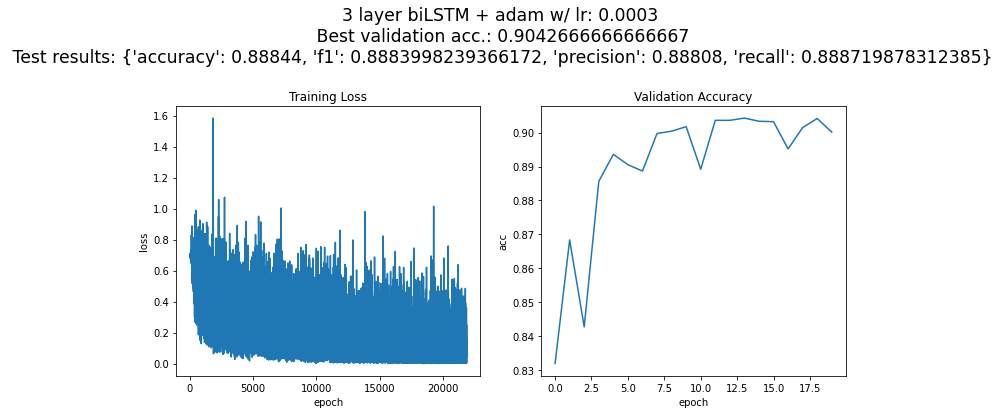

In [19]:
hidden_size = 256
num_layers = 3
num_classes = 2
bidirectional = True
torch.manual_seed(1234)

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

model = LSTMClassifier(embeddings,hidden_size,num_layers,num_classes,bidirectional)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.0003,betas=(0.9,0.999))

title = {'title': f'3 layer biLSTM + adam w/ lr: {0.0003}', 'file_name': f'lstm.png'}
show_result(model,device,criterion,optimizer,train_loader,val_loader,test_loader,title)

Using:
- `bidirectional LSTM` with `3 layers`, `256 hidden size dimensions`
- `batch size` of $16$ and `max dimension` of $512$
- `adam` with `learning rate` of `0.0003`
- `early stopping` with `patience = 5`

The model attained:
- $88.8\%$ accuracy
- $88.8\%$ f1 score
- $88.8\%$ precision
- $88.8\%$ recall

on `imdb` `test` set.